In [1]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import timeit

In [2]:
from gym.wrappers import Monitor

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
import math
import copy

In [5]:
class CartPoleAI(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc = nn.Sequential(
                        nn.Linear(4,128, bias=True),
                        nn.ReLU(),
                        nn.Linear(128,2, bias=True),
                        nn.Softmax(dim=1)
                        )

                
        def forward(self, inputs):
            x = self.fc(inputs)
            return x

In [6]:
def init_weights(m):
    
        # nn.Conv2d weights are of shape [16, 1, 3, 3] i.e. # number of filters, 1, stride, stride
        # nn.Conv2d bias is of shape [16] i.e. # number of filters
        
        # nn.Linear weights are of shape [32, 24336] i.e. # number of input features, number of output features
        # nn.Linear bias is of shape [32] i.e. # number of output features
        
        if ((type(m) == nn.Linear) | (type(m) == nn.Conv2d)):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.00)

In [7]:
def return_random_agents(num_agents):
    
    agents = []
    for _ in range(num_agents):
        
        agent = CartPoleAI()
        
        for param in agent.parameters():
            param.requires_grad = False
            
        init_weights(agent)
        agents.append(agent)
        
        
    return agents

In [8]:
def run_agents(agents):
    
    reward_agents = []
    env = gym.make("CartPole-v0")
    
    for agent in agents:
        agent.eval()
    
        observation = env.reset()
        
        r=0
        s=0
        
        for _ in range(250):
            
            inp = torch.tensor(observation).type('torch.FloatTensor').view(1,-1)
            output_probabilities = agent(inp).detach().numpy()[0]
            action = np.random.choice(range(game_actions), 1, p=output_probabilities).item()
            new_observation, reward, done, info = env.step(action)
            r=r+reward
            
            s=s+1
            observation = new_observation

            if(done):
                break

        reward_agents.append(r)        
        #reward_agents.append(s)
        
    
    return reward_agents

In [9]:
def return_average_score(agent, runs):
    score = 0.
    for i in range(runs):
        score += run_agents([agent])[0]
    return score/runs

In [10]:
def run_agents_n_times(agents, runs):
    avg_score = []
    for agent in agents:
        avg_score.append(return_average_score(agent,runs))
    return avg_score

In [11]:
def mutate(agent):

    child_agent = copy.deepcopy(agent)
    
    mutation_power = 0.02 #hyper-parameter, set from https://arxiv.org/pdf/1712.06567.pdf
            
    for param in child_agent.parameters():
    
        if(len(param.shape)==4): #weights of Conv2D

            for i0 in range(param.shape[0]):
                for i1 in range(param.shape[1]):
                    for i2 in range(param.shape[2]):
                        for i3 in range(param.shape[3]):
                            
                            param[i0][i1][i2][i3]+= mutation_power * np.random.randn()
                                
                                    

        elif(len(param.shape)==2): #weights of linear layer
            for i0 in range(param.shape[0]):
                for i1 in range(param.shape[1]):
                    
                    param[i0][i1]+= mutation_power * np.random.randn()
                        

        elif(len(param.shape)==1): #biases of linear layer or conv layer
            for i0 in range(param.shape[0]):
                
                param[i0]+=mutation_power * np.random.randn()

    return child_agent

In [12]:
def return_children(agents, sorted_parent_indexes, elite_index):
    
    children_agents = []
    
    #first take selected parents from sorted_parent_indexes and generate N-1 children
    for i in range(len(agents)-1):
        
        selected_agent_index = sorted_parent_indexes[np.random.randint(len(sorted_parent_indexes))]
        children_agents.append(mutate(agents[selected_agent_index]))

    #now add one elite
    elite_child = add_elite(agents, sorted_parent_indexes, elite_index)
    children_agents.append(elite_child)
    elite_index=len(children_agents)-1 #it is the last one
    
    return children_agents, elite_index

In [13]:
def add_elite(agents, sorted_parent_indexes, elite_index=None, only_consider_top_n=10):
    
    candidate_elite_index = sorted_parent_indexes[:only_consider_top_n]
    
    if(elite_index is not None):
        candidate_elite_index = np.append(candidate_elite_index,[elite_index])
        
    top_score = None
    top_elite_index = None
    
    for i in candidate_elite_index:
        score = return_average_score(agents[i],runs=5)
        print("Score for elite i ", i, " is ", score)
        
        if(top_score is None):
            top_score = score
            top_elite_index = i
        elif(score > top_score):
            top_score = score
            top_elite_index = i
            
    print("Elite selected with index ",top_elite_index, " and score", top_score)
    
    child_agent = copy.deepcopy(agents[top_elite_index])
    return child_agent

In [14]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)



Generation  0  | Mean rewards:  21.6046  | Mean of top 5:  27.45
Top  10  scores [87 98 58 73 68 20 36 19 61 60]
Rewards for top:  [27.89, 27.83, 27.29, 27.27, 26.97, 26.24, 26.21, 25.86, 25.73, 25.59]
Score for elite i  87  is  35.6
Score for elite i  98  is  21.6
Score for elite i  58  is  38.2
Score for elite i  73  is  24.4
Score for elite i  68  is  33.0
Score for elite i  20  is  20.0
Score for elite i  36  is  17.2
Score for elite i  19  is  13.8
Score for elite i  61  is  17.4
Score for elite i  60  is  39.4
Elite selected with index  60  and score 39.4


Generation  1  | Mean rewards:  25.440700000000003  | Mean of top 5:  31.875999999999998
Top  10  scores [43 49 35  2 18 20 89 36 74 93]
Rewards for top:  [32.44, 32.39, 31.77, 31.65, 31.13, 29.83, 29.77, 29.7, 29.49, 29.3]
Score for elite i  43  is  26.6
Score for elite i  49  is  26.4
Score for elite i  35  is  33.2
Score for elite i  2  is  27.4
Score for elite i  18  is  24.8
Score for elite i  20  is  24.0
Score for eli

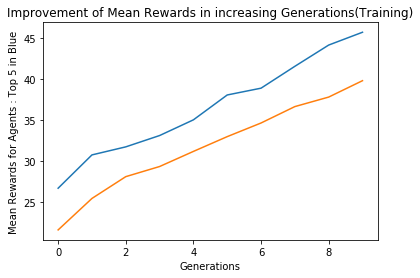

In [15]:
game_actions = 2 #2 actions possible: left or right
start = timeit.default_timer()
#disable gradients as we will not use them
torch.set_grad_enabled(False)

# initialize N number of agents
num_agents = 100
agents = return_random_agents(num_agents)

# How many top agents to consider as parents
top_limit = 10

# run evolution until X generations
generations = 10

elite_index = None
n=[]
m=[]

for generation in range(generations):

    # return rewards of agents
    rewards = run_agents_n_times(agents, 100) #return average of 3 runs

    # sort by rewards
    sorted_parent_indexes = np.argsort(rewards)[::-1][:top_limit] #reverses and gives top values (argsort sorts by ascending by default) https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order
    print("")
    print("")
    top_rewards = []
    
    for best_parent in sorted_parent_indexes:
        top_rewards.append(rewards[best_parent])
    
    print("Generation ", generation, " | Mean rewards: ", np.mean(rewards), " | Mean of top 5: ",np.mean(top_rewards[:5]))
    #print(rewards)
    print("Top ",top_limit," scores", sorted_parent_indexes)
    print("Rewards for top: ",top_rewards)
    
    m.append(np.mean(top_rewards))
    n.append(np.mean(rewards))
    # setup an empty list for containing children agents
    children_agents, elite_index = return_children(agents, sorted_parent_indexes, elite_index)

    # kill all agents, and replace them with their children
    agents = children_agents
stop = timeit.default_timer()
print('Time: ', stop - start) 
x=np.arange(generations)
plt.plot(x,m)
plt.plot(x,n)
plt.title('Improvement of Mean Rewards in increasing Generations(Training)')
plt.ylabel('Mean Rewards for Agents : Top 5 in Blue')
plt.xlabel('Generations')
plt.show()

In [16]:
def play_agent(agent):
        env = gym.make("CartPole-v0")
        
        env_record = Monitor(env, './video', force=True)
        observation = env_record.reset()
        last_observation = observation
        r=0
        j=[]
        episode_durations=[]
        timestep=0
        for timestep in range(250):
            env_record.render()
            inp = torch.tensor(observation).type('torch.FloatTensor').view(1,-1)
            output_probabilities = agent(inp).detach().numpy()[0]
            action = np.random.choice(range(game_actions), 1, p=output_probabilities).item()
            new_observation, reward, done, info = env_record.step(action)
            r=r+reward
            j.append(r)
            observation = new_observation

            if(done):
                break

        env_record.close()

        print("Rewards: ",r)

In [17]:
play_agent(agents[0])

Rewards:  47.0
